In [ ]:
# ф-ии для работы с кватернионами
import numpy as np
def quat_mult(q1, q2):
    q0 = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q1_ = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q2_ = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q3_ = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
    return np.array([q0, q1_, q2_, q3_])

def quat_conj(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

In [ ]:
# класс КА с маховиками (3)
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import norm

class SpacecraftSystemWithWheels:
    def __init__(self):
        self.mass = 100.0
        self.J = np.diag([10.0, 10.0, 5.0])
        self.J_wheels = np.array([0.1, 0.1, 0.1])
        self.max_torque = 0.2
        self.e_k = np.eye(3)
        self.mu = -3.986e14

        self.Kd = 1
        self.K = 1
        self.Kp_w = 2.0
        self.Kp_q = 4.0
        self.Ki_omega = 0.1
        self.Ki_q = 0.2
        self.Kd = 0.5
        self.Ki = 0.1

        self.integral = np.zeros(3)
        self.integral_omega = np.zeros(3)
        self.last_omega_error = np.zeros(3)
        self.integral_orientation = np.zeros(3)
        self.last_error = np.zeros(3)
        self.last_t = 0
        self.rng = np.random.default_rng(seed=42)

        self.F = np.diag(self.J_wheels) @ self.e_k

        self.state = np.concatenate([
            np.array([7000e3, 0, 0]),    # Положение
            np.array([0, 7.5e3, 0]),     # Скорость
            np.array([0.1, 0.2, -0.1]),  # Угловая скорость
            np.array([1, 0, 0, 0]),      # Кватернион
            np.zeros(3),                 # Скорость маховиков
            np.zeros(3)                  # Углы маховиков
        ])

        self.omega_target = np.array([0.05, -0.05, 0.01])
        self.Q_target = np.array([1, 0, 0, 0])
        self.Kq = np.diag([5.0, 5.0, 5.0])
        self.Kw = np.diag([2.0, 2.0, 2.0])

        self.results = {}

    def pid_control(self, omega_current, Q_current, t):
    
        dt = 0.1

        omega_error = self.omega_target - omega_current
        q_error = quat_mult(quat_conj(self.Q_target), Q_current)
        error_vec = q_error[1:]
        error = omega_error + error_vec

        P = self.Kp_w * omega_error + self.Kp_q * error_vec
        self.integral += error * dt
        I = self.Ki * self.integral
        derivative = (error - self.last_error) / dt
        D = self.Kd * derivative
        
        self.last_error = error
        return P + D 

    def sliding_mode_control(self, omega_current, Q_current, t):
        omega_error = omega_current - self.omega_target
        q_error = quat_mult(quat_conj(self.Q_target), Q_current)
        error_vec = q_error[1:]
        s = self.Kw @ omega_error + self.Kq @ error_vec
        u = -self.K * np.clip(s / 0.01, -1.0, 1.0)
        return u

    def lyapunov_control(self, omega_current, Q_current, t):
        q_error = quat_mult(quat_conj(self.Q_target), Q_current)
        error_vec = q_error[1:]
        omega_err = omega_current - self.omega_target
        u = -self.Kq @ error_vec - self.Kw @ omega_err
        return u

    def convergence_event(self, t, y):
        _, _, omega, _, _, _ = np.split(y, [3,6,9,13,16])
        error = omega - self.omega_target
        return norm(error) - 1e-3

    convergence_event.terminal = True
    convergence_event.direction = -1

    def compute_uk(self, M_pid, omega, omega_w):
        h = self.J_wheels * omega_w
        H_dot = -M_pid - np.cross(omega, h)

        if np.linalg.matrix_rank(self.F) == 3:
            u_k = np.linalg.pinv(self.F) @ H_dot
        else:
            u_k = self.F.T @ np.linalg.pinv(self.F @ self.F.T) @ H_dot

        return np.clip(u_k, -self.max_torque, self.max_torque), h, H_dot

    def dynamics(self, t, y, control_type="PID", noise_level=0.0):
        r, v, omega, Q, omega_w, fi = np.split(y, [3,6,9,13,16])
        r_norm = norm(r)
        a = self.mu * r / r_norm**3 if r_norm > 0 else np.zeros(3)

        omega_meas = omega + self.rng.normal(0, noise_level, size=3)
        Q_meas = Q + self.rng.normal(0, noise_level, size=4)
        Q_meas = Q_meas / norm(Q_meas)

        if control_type == "PID":
            M_control = self.pid_control(omega_meas, Q_meas, t)
        elif control_type == "Sliding":
            M_control = self.sliding_mode_control(omega_meas, Q_meas, t)
        elif control_type == "Lyapunov":
            M_control = self.lyapunov_control(omega_meas, Q_meas, t)
        else:
            raise ValueError(f"Unknown control type: {control_type}")

        u_k, h, H_dot = self.compute_uk(M_control, omega, omega_w)
        omega_dot = np.linalg.solve(self.J, M_control - np.cross(omega, self.J @ omega + h))

        Omega = np.array([
            [0, -omega[0], -omega[1], -omega[2]],
            [omega[0], 0, omega[2], -omega[1]],
            [omega[1], -omega[2], 0, omega[0]],
            [omega[2], omega[1], -omega[0], 0]
        ])
        Q_dot = 0.5 * Omega @ Q

        omega_w_dot = u_k / self.J_wheels
        fi_dot = omega_w

        return np.concatenate([v, a, omega_dot, Q_dot, omega_w_dot, fi_dot]), h, H_dot, u_k

    def run_simulation(self, control_type, noise_level=0.0):
        self.integral = np.zeros(3)
        self.last_error = np.zeros(3)

        logged_data = {
            't': [], 'H': [], 'H_dot': [], 'u_k': [], 'omega': [], 'Q': []
        }

        def wrapped_dynamics(t, y):
            y_dot, h, H_dot, u_k = self.dynamics(t, y, control_type, noise_level)
            logged_data['t'].append(t)
            logged_data['H'].append(h)
            logged_data['H_dot'].append(H_dot)
            logged_data['u_k'].append(u_k)
            _, _, omega, Q, _, _ = np.split(y, [3,6,9,13,16])
            logged_data['omega'].append(omega)
            logged_data['Q'].append(Q)
            return y_dot

        sol = solve_ivp(
            wrapped_dynamics, [0, 400], self.state, method='RK45',
            rtol=1e-6, atol=1e-8, events=self.convergence_event, max_step=0.5
        )

        self.results[control_type + ('_noisy' if noise_level > 0 else '')] = {
            'time': np.array(logged_data['t']),
            'H': np.array(logged_data['H']).T,
            'H_dot': np.array(logged_data['H_dot']).T,
            'u_k': np.array(logged_data['u_k']).T,
            'omega': np.array(logged_data['omega']).T,
            'Q': np.array(logged_data['Q']).T,
            'solution': sol
        }

    def simulate_all(self):
        self.run_simulation("PID")
        self.run_simulation("Sliding")
        self.run_simulation("Lyapunov")
        print("Все симуляции завершены. Результаты сохранены в self.results")

    def plot_results(self):
        if not self.results:
            print("Сначала выполните симуляцию с помощью метода simulate_all()")
            return

        fig, axs = plt.subplots(3, 2, figsize=(16, 12))  # 3 строки, 2 столбца
        titles = [
            ["H(t) - PID", "H'(t) - PID"],
            ["H(t) - Sliding", "H'(t) - Sliding"],
            ["H(t) - Lyapunov", "H'(t) - Lyapunov"]
        ]
        keys = ['PID', 'Sliding', 'Lyapunov']

        for i, key in enumerate(keys):
            if key not in self.results:
                continue
                
            res = self.results[key]
            t = res['time']
            H = res['H']
            H_dot = res['H_dot']

            # График H(t)
            axs[i, 0].plot(t, H.T)
            axs[i, 0].set_title(titles[i][0])
            axs[i, 0].legend(["Hx", "Hy", "Hz"])
            axs[i, 0].set_xlabel("Time (s)")
            axs[i, 0].grid(True)

            # График H'(t)
            axs[i, 1].plot(t, H_dot.T)
            axs[i, 1].set_title(titles[i][1])
            axs[i, 1].legend(["Hx'", "Hy'", "Hz'"])
            axs[i, 1].set_xlabel("Time (s)")
            axs[i, 1].grid(True)

        plt.tight_layout()
        plt.show()


Все симуляции завершены. Результаты сохранены в self.results


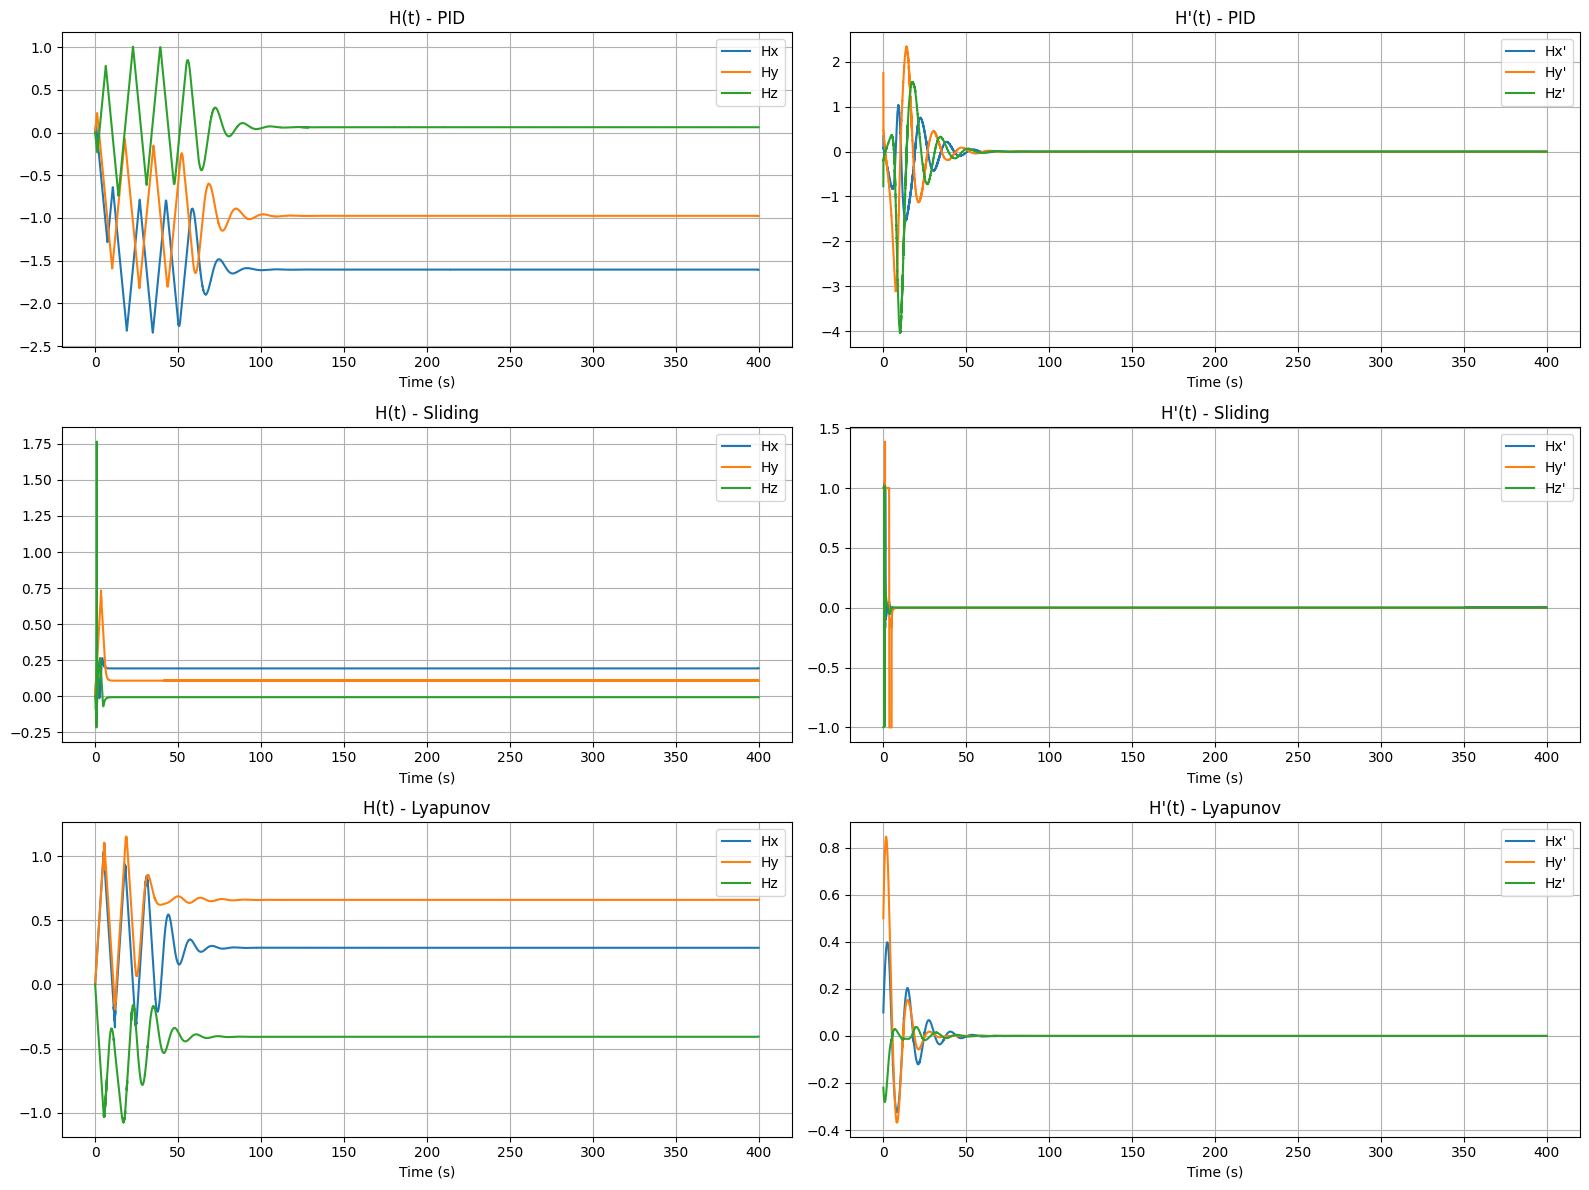

In [72]:
sc = SpacecraftSystemWithWheels()
sc.simulate_all() 

sc.plot_results()